# Calibración y análisis — Modelo de Tanques

In [1]:

import pandas as pd
import numpy as np
from tank_model import TankModel, ModelConfig, nse, kge, bias_pct
from tank_model.parameters import Parameters
from tank_model.io import load_csv, subset_period, tag_hydrology
from tank_model.et import ensure_pet

# 1) Cargar datos
df = load_csv('../data/example_forcing.csv')
df.head()


,P_mm,PET_mm
date,,
2020-01-01,0,3
2020-01-02,5,3
2020-01-03,2,3
2020-01-04,0,3
2020-01-05,0,3


<Axes: title={'center': 'P y PET'}, xlabel='date'>

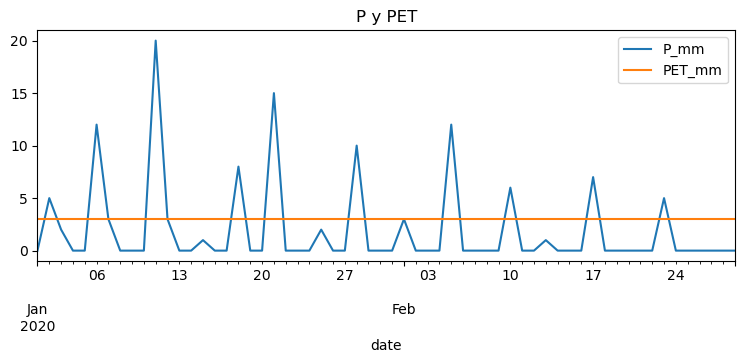

In [2]:

# 2) Asegurar PET con Cenicafé (si tienes Tmean_C y Rs_MJ_m2_d en tu CSV)
# df = ensure_pet(df, method='cenicafe', a=0.0135, b=17.78)
# Para el ejemplo ya existe PET_mm:
df = ensure_pet(df, method='column')
df[['P_mm','PET_mm']].plot(title='P y PET', figsize=(9,3))


<Axes: title={'center': 'Qout (mm/dt)'}, xlabel='date'>

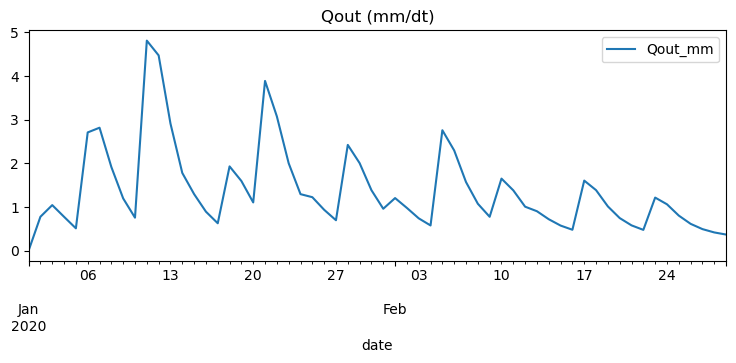

In [3]:

# 3) Configurar y correr
cfg = ModelConfig(dt_hours=24.0, area_km2=5.0, route=True)
p = Parameters()
m = TankModel(p, cfg)
sim = m.run(df)
sim[['Qout_mm']].plot(title='Qout (mm/dt)', figsize=(9,3))


In [4]:

# 4) Análisis seco/húmedo y métricas por régimen
reg = tag_hydrology(df, col='P_mm', dry_q=0.25, wet_q=0.75)
sim['regime'] = reg
sim.groupby('regime')['Qout_mm'].describe()


,count,mean,std,min,25%,50%,75%,max
regime,,,,,,,,
dry,18.0,0.663712,0.289235,0.000000,0.481900,0.620282,0.870264,1.215615
normal,26.0,1.246984,0.517365,0.510838,0.807719,1.089557,1.589492,2.423049
wet,16.0,2.432465,1.216629,0.755324,1.295137,2.355621,2.954308,4.813170


In [5]:

# 5) NSE/KGE por subperíodos (ejemplo sintético con obs = sim + ruido)
obs = sim['Qout_mm'] * (1 + np.random.normal(0, 0.1, size=len(sim)))
print('NSE total:', nse(obs, sim['Qout_mm']))
for r in ['dry','normal','wet']:
    mask = sim['regime'] == r
    print(r, 'NSE=', nse(obs[mask], sim.loc[mask,'Qout_mm']))


NSE total: 0.9532386611908714
dry NSE= 0.9129929130379608
normal NSE= 0.9437332086234443
wet NSE= 0.8966457573318125


## 6) Comparación de caudal simulado vs observado

Se carga el archivo `example_discharge.csv` con caudales observados (m³/s) y se compara con el caudal simulado convertido a m³/s en el paso anterior.

<Axes: title={'center': 'Caudal simulado vs observado'}, xlabel='date'>

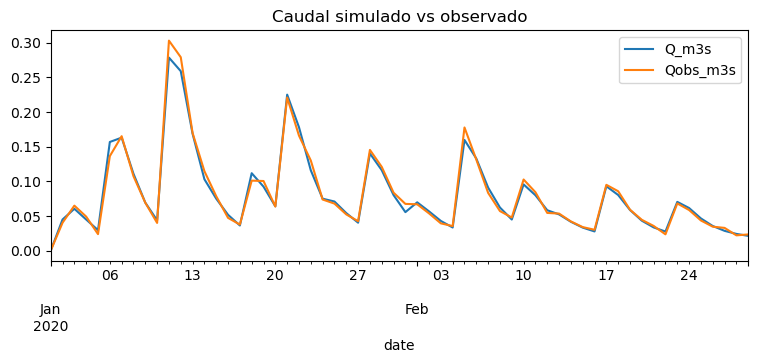

In [6]:

# 6) Comparación caudal simulado vs observado
df_obs = load_csv('../data/example_discharge.csv')
# Asegurar que la columna se llame 'Qobs_m3s'
if 'Qobs_m3s' not in df_obs.columns:
    raise ValueError('La columna Qobs_m3s no se encuentra en example_discharge.csv')
# Unir las series por fecha y graficar
comp = sim[['Q_m3s']].join(df_obs['Qobs_m3s'].rename('Qobs_m3s'), how='inner')
comp.plot(title='Caudal simulado vs observado', figsize=(9,3))

## 7) Registrar calibración y usar calibraciones guardadas

A continuación se muestra cómo registrar una calibración en el archivo de log, consultar las últimas calibraciones registradas para una cuenca y aplicar una calibración guardada a un conjunto de forzantes distinto.

In [9]:
# 7a) Registrar calibración en el log y listar calibraciones recientes
from tank_model.calibration import random_search, list_recent_calibrations

def make_model(p):
    return TankModel(params=p, config=cfg)

# Para este ejemplo utilizamos la simulación previa como 'observada' con algo de ruido
q_obs = sim['Q_m3s'].values * (1 + np.random.normal(0, 0.1, size=len(sim)))

# Nombre de la cuenca para registrar la calibración
catchment_name = 'ExampleCuenca'
log_path = '../data/calibrations_example.csv'

# Ejecutar búsqueda aleatoria y guardar en el log
best_p, best_score = random_search(
    make_model,
    df,
    q_obs,
    n_iter=20,
    seed=123,
    catchment_name=catchment_name,
    log_path=log_path,
)
print(f'Mejor NSE registrado: {best_score:.3f}')

# Listar las 5 últimas calibraciones para esta cuenca
df_recent = pd.DataFrame(list_recent_calibrations(catchment_name, n=5, log_path=log_path))
print('Últimas calibraciones registradas:')
df_recent


Mejor NSE registrado: 0.926
Últimas calibraciones registradas:


,id,timestamp,catchment,score,S0_max,alpha,beta,k_qs,k_inf,k_perc,phi,k_qf,k_bf,f_et0,f_et1,n_r,k_r,id_num
0,0,2025-08-07T23:23:38,ExampleCuenca,0.9256468512569799,80.68036234508456,1.69306573307467,1.1527447610345614,0.08106198126015493,0.14330192904898234,0.04012358465409101,0.6617468438860865,0.2215658400667005,0.044465227941883075,0.006867369651729605,0.09816170341916325,1,52.46739832566098,0


<Axes: title={'center': 'Caudal simulado con calibración guardada en nuevos forzantes'}, xlabel='date'>

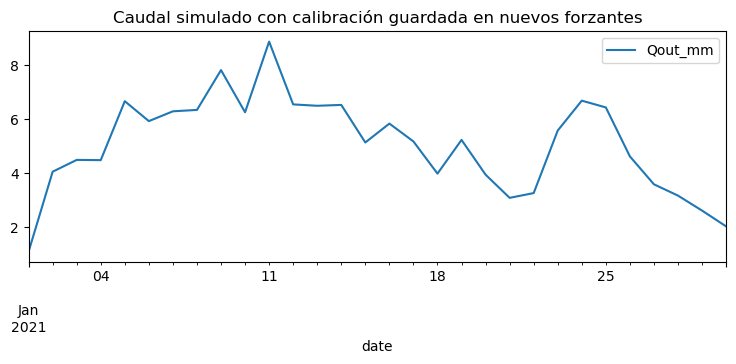

In [11]:
# 7b) Aplicar la calibración guardada a nuevos forzantes
df_new = load_csv('../data/new_forcing.csv')
from tank_model.calibration import run_with_saved_calibration

# Ejecutar el modelo con la última calibración registrada (ID por defecto)
sim_new = run_with_saved_calibration(make_model, df_new, catchment_name=catchment_name, log_path=log_path)

sim_new[['Qout_mm']].plot(title='Caudal simulado con calibración guardada en nuevos forzantes', figsize=(9,3))


## 8) Calcular PET con Cenicafé usando datos de Medellín

Se ha generado un archivo `medellin_pet_inputs.csv` con valores sintéticos de temperatura media (`Tmean_C`) y radiación solar global (`Rs_MJ_m2_d`) basados en rangos típicos reportados para Medellín. A continuación se calcula la PET empleando la fórmula de Cenicafé con los coeficientes por defecto y se muestran los primeros valores.

<Axes: title={'center': 'PET calculada para Medellín (Cenicafé)'}, xlabel='date'>

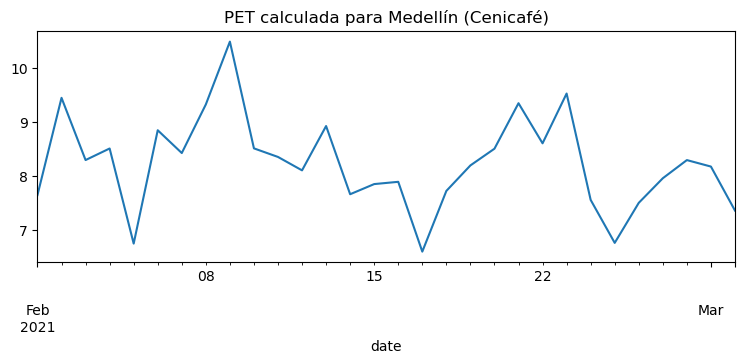

In [12]:
# 8) Cargar datos de temperatura y radiación de Medellín y calcular PET con Cenicafé
df_med = pd.read_csv('../data/medellin_pet_inputs.csv', parse_dates=['date'])
df_med = df_med.set_index('date')
# Calcular PET con el método de Cenicafé
df_med_pet = ensure_pet(df_med, method='cenicafe')
df_med_pet[['Tmean_C','Rs_MJ_m2_d','PET_mm']].head()

# Graficar PET resultante
df_med_pet['PET_mm'].plot(title='PET calculada para Medellín (Cenicafé)', figsize=(9,3))